# Emulating CLASS data

## Import Packages

In [1]:
import os
import numpy as np
import random

import pandas as pd
import time
import matplotlib.pyplot as plt


from looti import dictlearn as dcl
from looti import datahandle as dhl
from looti import plotting as pm
from looti import tools as too

In [2]:
%matplotlib inline

In [3]:
df1 = pd.read_csv('../data/ClassLhs_tcl2500_1000.csv', index_col=list(range(14)))
df1

1  \
data_type redshift parameter_1 parameter_1_value parameter_2 parameter_2_value parameter_3 parameter_3_value parameter_4 parameter_4_value parameter_5 parameter_5_value parameter_6 parameter_6_value                 
tcl       0.0      omega_b     0.023059          omega_cdm   0.122982          H0          67.4437           A_s         2.035097e-09      n_s         0.96184           tau_reio    0.076921           1.350520e-10   
                               0.022204          omega_cdm   0.123558          H0          67.4329           A_s         2.124773e-09      n_s         0.95156           tau_reio    0.082979           1.484411e-10   
                               0.023034          omega_cdm   0.123990          H0          66.5095           A_s         2.064989e-09      n_s         0.95824           tau_reio    0.043705           1.358185e-10   
                               0.022734          omega_cdm   0.122286          H0          68.7829           A_s         2.161574e-09      n_s         0.95536           tau_reio    0.031733           1.492762e-10   
                               0.022359          omega_cdm   0.121746          H0          68.1403           A_s         2.154807e-09      n_s         0.95956           tau_reio    0.039982           1.453962e-10   
...                                                                                                                                                                                                              ...   
                               0.022914          omega_cdm   0.124326          H0          64.8679           A_s         2.124209e-09      n_s         0.94618           tau_reio    0.030492           1.439524e-10   
                               0.021633          omega_cdm   0.114042          H0          70.0249           A_s         2.080076e-09      n_s         0.96290           tau_reio    0.083929           1.482745e-10   
                               0.021742          omega_cdm   0.125682          H0          65.3431           A_s         2.047928e-09      n_s         0.96108           tau_reio    0.073927           1.315521e-10   
                               0.022723          omega_cdm   0.119982          H0          66.6769           A_s         2.087831e-09      n_s         0.96280           tau_reio    0.087287           1.382831e-10   
l_grid    NaN      NaN         NaN               NaN         NaN               NaN         NaN               NaN         NaN               NaN         NaN               NaN         NaN                2.000000e+00   

                                                                                                                                                                                                                   2  \
data_type redshift parameter_1 parameter_1_value parameter_2 parameter_2_value parameter_3 parameter_3_value parameter_4 parameter_4_value parameter_5 parameter_5_value parameter_6 parameter_6_value                 
tcl       0.0      omega_b     0.023059          omega_cdm   0.122982          H0          67.4437           A_s         2.035097e-09      n_s         0.96184           tau_reio    0.076921           1.277189e-10   
                               0.022204          omega_cdm   0.123558          H0          67.4329           A_s         2.124773e-09      n_s         0.95156           tau_reio    0.082979           1.400288e-10   
                               0.023034          omega_cdm   0.123990          H0          66.5095           A_s         2.064989e-09      n_s         0.95824           tau_reio    0.043705           1.292912e-10   
                               0.022734          omega_cdm   0.122286          H0          68.7829           A_s         2.161574e-09      n_s         0.95536           tau_reio    0.031733           1.412794e-10   
                               0.022359          omega_cdm   0.121746          H0          68.1403        

# Import Data

In [4]:
data_folder = '../data/' 
results_folder = '../results/'

In [5]:
###Name of the file for the external input data, without the extension
datafile_ext = 'ClassLhs_tcl2500_1000'
###Name of the file for the LCDM input data
datafile_ref = 'ClassLhs_tcl2500_ref'

In [6]:
emulation_data = dhl.DataHandle(datafile_ext, 
                                data_folder, 
                                datafile_ref, 
                                num_parameters=6, 
                                data_type='tcl',
                                features_name='l_grid', 
                                features_to_Log=True, 
                                ratio_mode=False) 
emulation_data.read_csv_pandas()

## Calculate power spectra ratios at all redshifts available

In [7]:
## Set normalize=False, since Fitting Formulae are already normalized
## First argument contains all the redshifts at which simulations are available
emulation_data.calculate_ratio_by_redshifts(emulation_data.z_vals, normalize=True)

# Define number of training and test

In [8]:
### Available parameters 
n_train = 300 # Number of training vectors without taking acount the extrema 
n_test = 20 # Number of test vectors without taking acount the extrema
n_splits = 3  # Number of splits
test_indices=[random.sample(range(1, 2000), 20), random.sample(range(1, 2000), 20), random.sample(range(1, 2000), 20)]  ## List of list of indices, one list per split

In [9]:
emulation_data.calculate_data_split(n_train=n_train, ##number of training vectors/ redshift
                                    n_test=n_test, ##number of test vectors
                                    n_splits=n_splits,
                                    verbosity=3,
                                    manual_split=True,
                                    test_indices=test_indices,
                                    train_redshift_indices=[0],##Indices of the redshifts used for the train vect.
                                    test_redshift_indices=[0]) ##Indices of the redshifts used for the test vect.

('number of wanted training vectors', 300)
('number of wanted test vectors', 20)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))


#  PCA with GP interpolation

In [10]:
npca = 8

In [11]:
ratios_predicted , emulation_data, intobj = dcl.Predict_ratio(emulation_data,Operator="PCA",
                                                              train_noise=1e-10, ##noise for the GP's kernel
                                                              gp_n_rsts=40,##times allowed to restart the optimiser
                                                              ncomp=npca, ##number of components
                                                              gp_const=1, ##Constant for the RBF kernel
                                                              gp_length=np.ones(6) , ## Length for GP 
                                                              interp_type='GP', ##kind of interpolator,e.g int1d or GP 
                                                              n_splits=n_splits, ##number of splits
                                                              test_indices=test_indices, ##indices of the test vectors
                                                              interp_dim=1,
                                                              return_interpolator=True,
                                                              pca_norm=True
                                                              # min_k =1e-2,ma_k=10e1
                                                              )

('Shape of PCA matrix: (302, 8)',)
('Number of PCA components: 8',)


In [12]:
import pickle
filename = 'gp_tcl.sav'
pickle.dump(intobj, open(filename, 'wb'))

In [13]:
colors = plt.cm.coolwarm(np.linspace(0, 1, n_train +2))
colors_pca = plt.cm.coolwarm(np.linspace(0, 1, npca))

Text(0.5, 1.0, 'spectra')

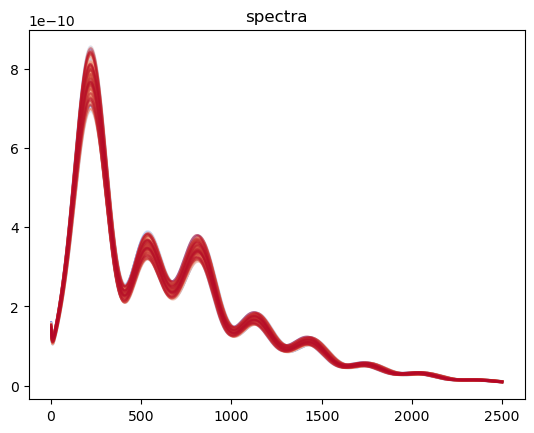

In [14]:
spectra = emulation_data.df_ext.loc['tcl'].values
for spec, color in zip(spectra, colors):
    plt.plot(np.linspace(1, 2499, 2499), spec, c=color, alpha=0.5)
plt.title('spectra')

TRAINING DATA: (302, 2499)


Text(0.5, 1.0, 'spectra normed')

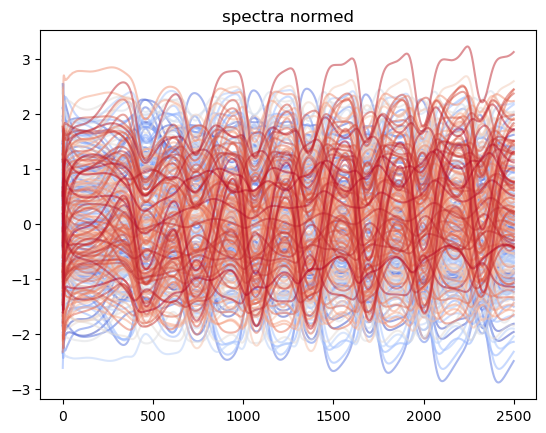

In [15]:
trainspace_matrix = intobj.trainspace_mat
print('TRAINING DATA:', trainspace_matrix.shape)
for spec, color in zip(trainspace_matrix, colors):
    plt.plot(np.linspace(1, 2499, 2499), spec, c=color, alpha=0.5)
plt.title('spectra normed')

PCA RAW: (302, 8)


Text(0.5, 1.0, 'pca')

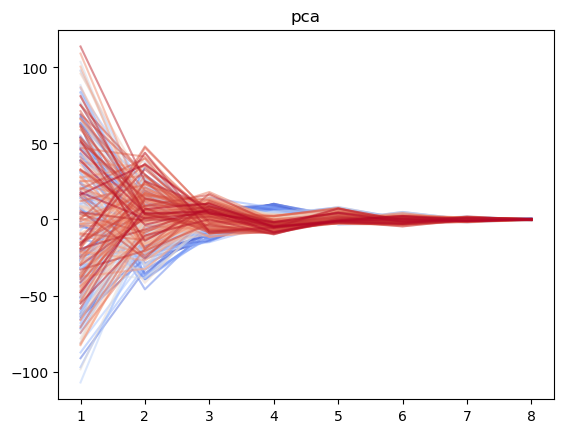

In [16]:
pca_raw = intobj.pca.fit(trainspace_matrix).transform(trainspace_matrix)
print('PCA RAW:', pca_raw.shape)
for pcar, color in zip(pca_raw, colors):
    plt.plot(np.linspace(1, npca, npca), pcar, c=color, alpha=0.5)
plt.title('pca')

PCA: (302, 8)


Text(0.5, 1.0, 'pca normed')

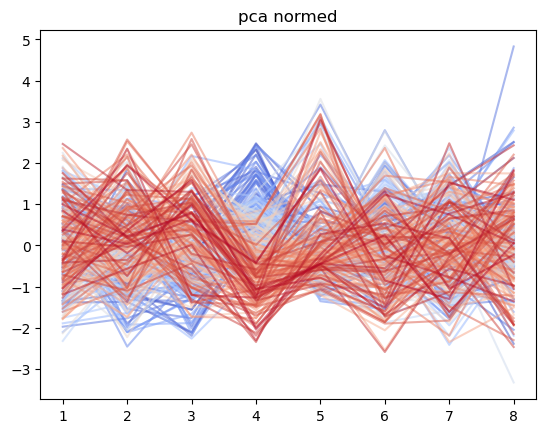

In [17]:
pca_test = intobj.representation
print('PCA:', pca_test.shape)
for pca, color in zip(pca_test, colors):
    plt.plot(np.linspace(1, npca, npca), pca, c=color, alpha=0.5)
plt.title('pca normed')

Text(0, 0.5, 'Normed Input Values')

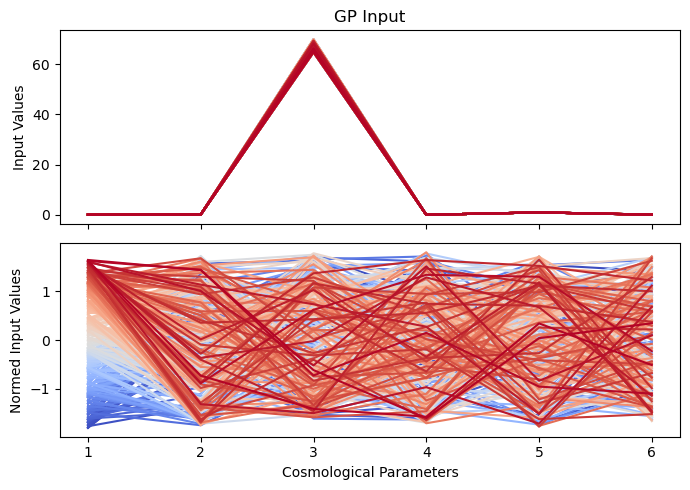

In [18]:
trainspace_raw = intobj.trainspace
trainspace_normed = (trainspace_raw - trainspace_raw.mean(axis=0)) / trainspace_raw.std(axis=0)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)

for tsr, color in zip(trainspace_raw, colors):
    ax[0].plot(np.linspace(1, 6, 6), tsr, c=color)
ax[0].set_ylabel('Input Values')
ax[0].set_xticklabels([])
ax[0].set_title('GP Input')


for tsr, color in zip(trainspace_normed, colors):
    ax[1].plot(np.linspace(1, 6, 6), tsr, c=color)
ax[1].set_xlabel('Cosmological Parameters')
ax[1].set_ylabel('Normed Input Values')

Text(0, 0.5, 'Residuals')

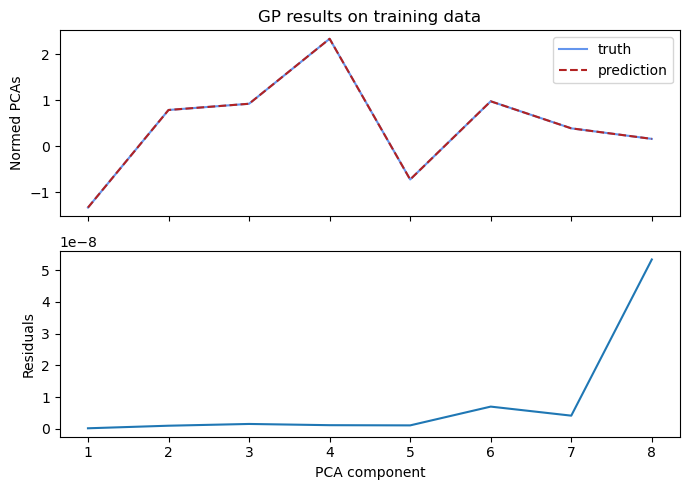

In [19]:
plot_index = 0
xtrain = (emulation_data.train_samples - emulation_data.train_samples.mean(axis=0)) / emulation_data.train_samples.std(axis=0)
prediction_pca_normed = intobj.gp_regressor.predict(xtrain)
truth_pca_normed = intobj.representation
fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, npca, npca), truth_pca_normed[plot_index], c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, npca, npca), prediction_pca_normed[plot_index], c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Normed PCAs')
ax[0].set_xticks(np.arange(1, npca+1))
ax[0].set_xticklabels([])
ax[0].set_title('GP results on training data')

residuals = np.abs(1- (prediction_pca_normed/truth_pca_normed))
ax[1].plot(np.linspace(1, npca, npca), residuals[plot_index])
ax[1].set_xticks(np.arange(1, npca+1))
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')

Text(0.5, 1.0, 'pca reconstructed')

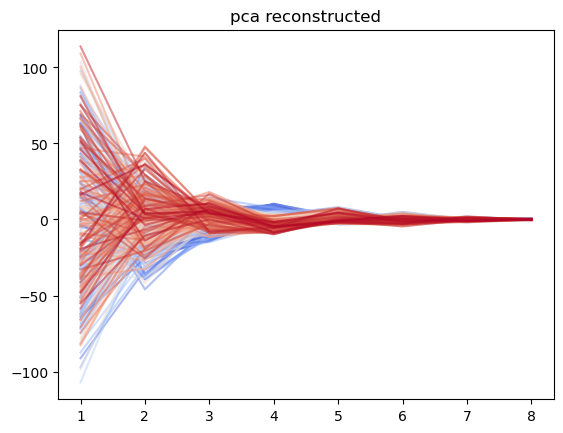

In [20]:
interp_atoms_normed = intobj.gp_regressor.predict(xtrain)
interp_atoms = interp_atoms_normed * intobj.matPCA_std + intobj.matPCA_mean
for interp, color in zip(interp_atoms, colors):
    plt.plot(np.linspace(1, npca, npca), interp, c=color, alpha=0.5)
plt.title('pca reconstructed')

Text(0, 0.5, 'Residuals')

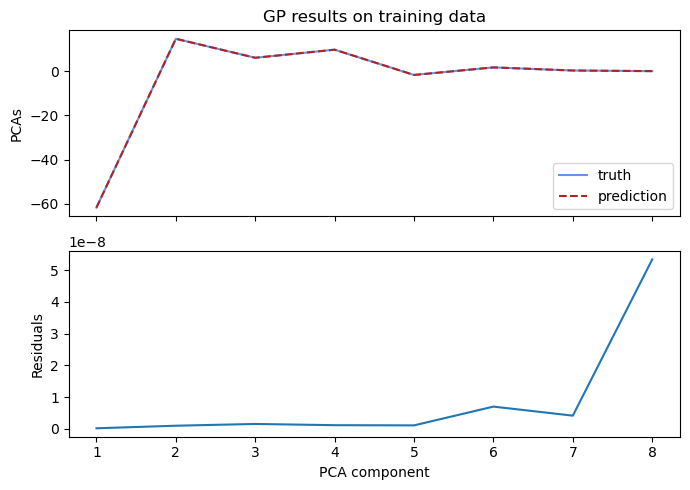

In [21]:
prediction_pca = prediction_pca_normed * intobj.matPCA_std + intobj.matPCA_mean
truth_pca = truth_pca_normed * intobj.matPCA_std + intobj.matPCA_mean

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, npca, npca), truth_pca[plot_index], c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, npca, npca), prediction_pca[plot_index], c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('PCAs')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on training data')

residuals = np.abs(1- (prediction_pca/truth_pca))
ax[1].plot(np.linspace(1, npca, npca), residuals[plot_index])
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')

Text(0, 0.5, 'Residuals')

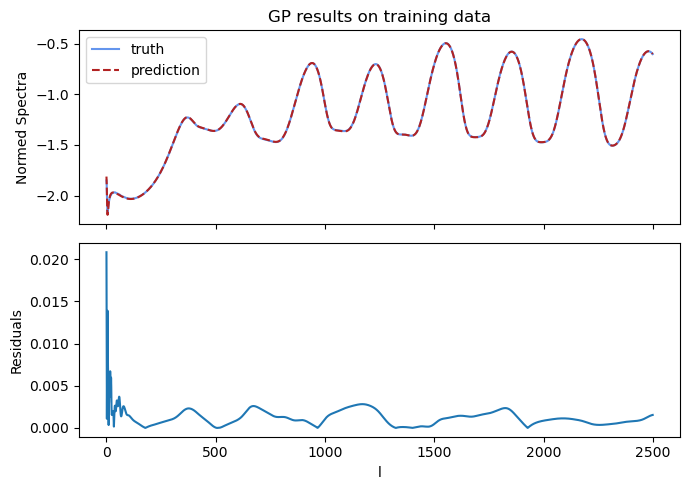

In [22]:
truth_spectrum_normed_train = intobj.trainspace_mat[plot_index]
prediction_spectrum_normed_train = intobj.reconstruct_data(emulation_data.train_samples, pca_norm=True)[plot_index]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, 2499, 2499), truth_spectrum_normed_train, c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, 2499, 2499), prediction_spectrum_normed_train, c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Normed Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on training data')

residuals = np.abs(1- (prediction_spectrum_normed_train/truth_spectrum_normed_train))
ax[1].plot(np.linspace(1, 2499, 2499), residuals)
ax[1].set_xlabel('l')
ax[1].set_ylabel('Residuals')

In [23]:
binwise_mean = emulation_data.binwise_mean
binwise_std = emulation_data.binwise_std
ref = emulation_data.df_ref.loc['tcl'].values

In [24]:
10**emulation_data.fgrid

array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.497e+03, 2.498e+03,
       2.499e+03])

Text(0, 0.5, 'Residuals')

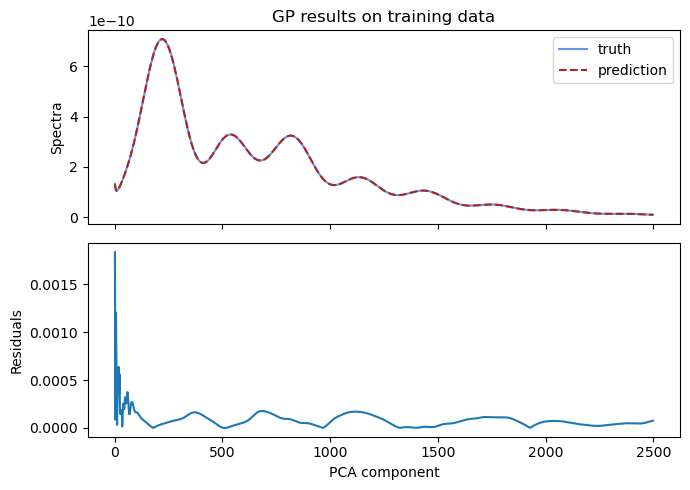

In [25]:
truth_spectrum_train = (truth_spectrum_normed_train * binwise_std + binwise_mean) * ref
prediction_spectrum_train = (prediction_spectrum_normed_train * binwise_std + binwise_mean) * ref


fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, 2499, 2499), truth_spectrum_train.flatten(), c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, 2499, 2499), prediction_spectrum_train.flatten(), c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on training data')

residuals = np.abs(1 - prediction_spectrum_train.flatten() / truth_spectrum_train.flatten())
ax[1].plot(np.linspace(1, 2499, 2499), residuals)
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')

In [26]:
indexvalues = emulation_data.test_samples[plot_index]
truth_spectrum = emulation_data.df_ext.loc['tcl', 0.0, 'omega_b', indexvalues[0], 'omega_cdm', indexvalues[1], 'H0', indexvalues[2], 'A_s', indexvalues[3], 'n_s', indexvalues[4], 'tau_reio', indexvalues[5]].values.flatten()

ref_spectrum = emulation_data.df_ref.loc['tcl'].values.flatten()
truth_spectrum_normed = (truth_spectrum/ref_spectrum - emulation_data.binwise_mean) / emulation_data.binwise_std
prediction_spectrum_normed = intobj.predict(emulation_data.test_samples, pca_norm=True)[tuple(indexvalues)]

In [27]:
indexvalues = emulation_data.test_samples[plot_index]
ref_spectrum = emulation_data.df_ref.loc['tcl'].values.flatten()
truth_spectrum_test = emulation_data.df_ext.loc['tcl', 0.0, 
                                                'omega_b', indexvalues[0], 
                                                'omega_cdm', indexvalues[1], 
                                                'H0', indexvalues[2], 
                                                'A_s', indexvalues[3], 
                                                'n_s', indexvalues[4], 
                                                'tau_reio', indexvalues[5]].values.flatten()

truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std

truth_pca_test1 = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
truth_pca_test = (truth_pca_test1 - intobj.matPCA_mean) / intobj.matPCA_std
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)

In [28]:
truth_normed_pcas_list = []

for ii in range(20):
    indexvalues = emulation_data.test_samples[ii]
    ref_spectrum = emulation_data.df_ref.loc['tcl'].values.flatten()
    truth_spectrum_test = emulation_data.df_ext.loc['tcl', 0.0, 
                                                    'omega_b', indexvalues[0], 
                                                    'omega_cdm', indexvalues[1], 
                                                    'H0', indexvalues[2], 
                                                    'A_s', indexvalues[3], 
                                                    'n_s', indexvalues[4], 
                                                    'tau_reio', indexvalues[5]].values.flatten()

    truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std
    truth_pca_test_raw = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
    truth_pca_test = (truth_pca_test_raw - intobj.matPCA_mean) / intobj.matPCA_std
    truth_normed_pcas_list.append(truth_pca_test)

truth_normed_pcas = np.array(truth_normed_pcas_list)

In [39]:
xtest.shape

(20, 6)

In [37]:
len(emulation_data.test_splitdict[0])

20

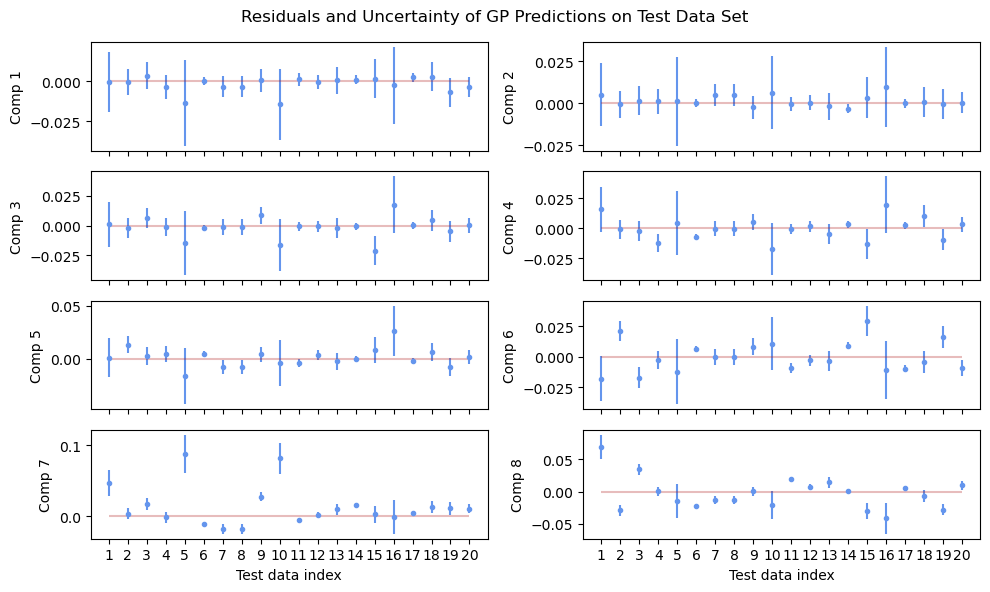

In [29]:
grid = np.linspace(1, n_test, n_test)
fig, axs = plt.subplots(nrows=int(np.ceil(npca/2)), ncols=2, figsize=(10,6))
#plt.subplots_adjust(hspace=0.5)
fig.suptitle('Residuals and Uncertainty of GP Predictions on Test Data Set')

for comp, ax in enumerate(axs.ravel()):
    ax.errorbar(grid, 
                 truth_normed_pcas[:,comp]-prediction_pca_test[:,comp], 
                 yerr=std_pca_test[:,comp], 
                 linestyle='', marker='.', color='cornflowerblue')
    ax.hlines(0, 1, 20, color='firebrick', alpha=0.3)

    ax.set_ylabel("Comp %i" %(comp+1))
    ax.set_xticks(list(range(1,n_test+1)))
    ax.set_xticklabels([])

for i in range(2):
    axs[-1, i].set_xlabel('Test data index')
    axs[-1, i].set_xticklabels(list(range(1, n_test+1)))

plt.tight_layout()
plt.show()

In [30]:
plot_index = 5

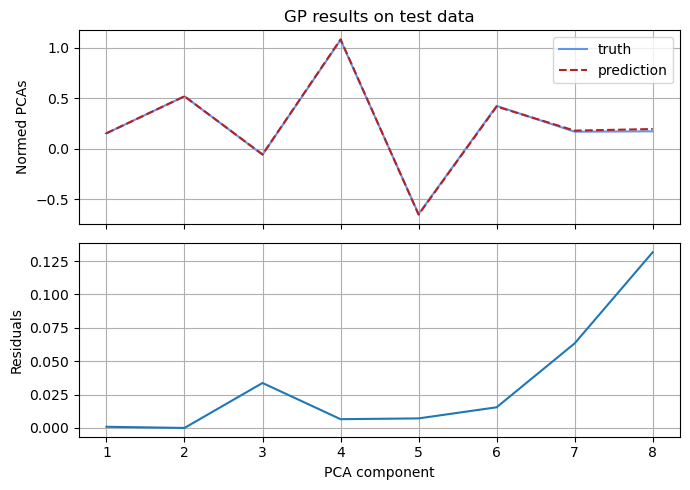

In [31]:
indexvalues = emulation_data.test_samples[plot_index]
ref_spectrum = emulation_data.df_ref.loc['tcl'].values.flatten()
truth_spectrum_test = emulation_data.df_ext.loc['tcl', 0.0, 
                                                'omega_b', indexvalues[0], 
                                                'omega_cdm', indexvalues[1], 
                                                'H0', indexvalues[2], 
                                                'A_s', indexvalues[3], 
                                                'n_s', indexvalues[4], 
                                                'tau_reio', indexvalues[5]].values.flatten()

truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std

truth_pca_test1 = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
truth_pca_test = (truth_pca_test1 - intobj.matPCA_mean) / intobj.matPCA_std
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)
# prediction_pca_test = intobj.interpolated_atoms(xtest)[plot_index]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, npca, npca), truth_pca_test, c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, npca, npca), prediction_pca_test[plot_index], c='firebrick', linestyle='--', label='prediction')
ax[0].errorbar(np.linspace(1, npca, npca), prediction_pca_test[plot_index], yerr=std_pca_test[plot_index], linestyle='', color='firebrick')
ax[0].legend()
ax[0].set_ylabel('Normed PCAs')
ax[0].set_xticks(np.arange(1, npca+1))
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
ax[0].grid()

residuals = np.abs(1- (prediction_pca_test[plot_index]/truth_pca_test))
ax[1].plot(np.linspace(1, npca, npca), residuals)
ax[1].set_xticks(np.arange(1, npca+1))
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
ax[1].grid()

In [32]:
loaded_gp = pickle.load(open(filename, 'rb'))
normed = loaded_gp.gp_regressor.predict(xtrain)

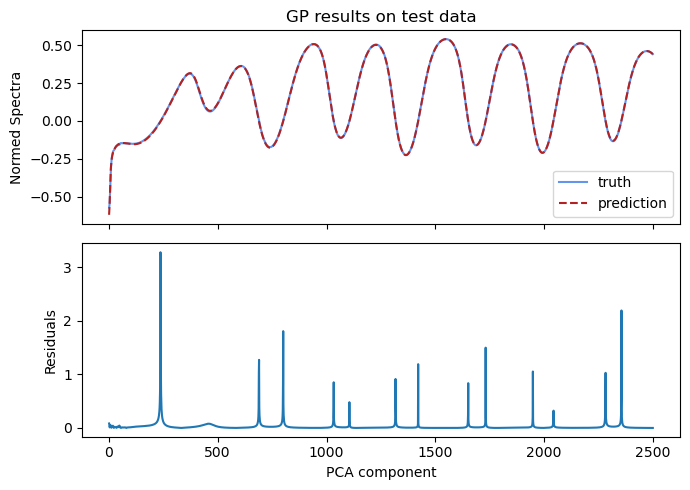

In [33]:
prediction_spectrum_normed_test = loaded_gp.predict(emulation_data.test_samples, pca_norm=True)[tuple(indexvalues)]
# prediction_spectrum_normed = ratios_predicted[tuple(emulation_data.test_samples[plot_index])]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, 2499, 2499), truth_spectrum_normed_test, c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, 2499, 2499), prediction_spectrum_normed_test, c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Normed Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
# ax[0].hlines(0, 1, 2499, color='black', alpha=0.3)

residuals = np.abs(1 - prediction_spectrum_normed_test / truth_spectrum_normed_test)
ax[1].plot(np.linspace(1, 2499, 2499), residuals)
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
plt.show()

In [34]:
# prediction_spectrum_test = (prediction_spectrum_normed_test * binwise_std + binwise_mean) * ref
prediction_spectrum_test = dcl.reconstruct_spectra(prediction_spectrum_normed_test)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, 2499, 2499), truth_spectrum_test, c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, 2499, 2499), prediction_spectrum_test.flatten(), c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')

residuals = np.abs(1 - prediction_spectrum_test.flatten() / truth_spectrum_test)
ax[1].plot(np.linspace(1, 2499, 2499), residuals)
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')

TypeError: reconstruct_spectra() missing 1 required positional argument: 'emulation_data'

In [ ]:
pca = intobj.pca

X_train_pca = pca.fit_transform(trainspace_matrix)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
fig, ax = plt.subplots(2, figsize=(7, 5))
ax[0].step(range(1, len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
ax[0].bar(range(1, len(exp_var_pca)+1), exp_var_pca, alpha=0.3, align='center', label='Individual explained variance')
ax[0].vlines(x=1, ymin=0, ymax=cum_sum_eigenvalues[0])
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_xticks(list(range(npca+1)))
ax[0].legend(loc=(0.54, 0.63))

ax[1].step(range(1, len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
ax[1].bar(range(1, len(exp_var_pca)+1), exp_var_pca, alpha=0.3, align='center', label='Individual explained variance')
ax[1].vlines(x=1, ymin=0, ymax=cum_sum_eigenvalues[0])
ax[1].set_ylabel('Explained variance ratio')
ax[1].set_xlabel('PCA component')
ax[1].set_yscale('log')
ax[1].set_xticks(list(range(npca+1)))
ax[1].legend(loc=(0.54, 0.63))
plt.tight_layout()
plt.show()

In [ ]:
pca_transpose = pca_raw.T
label_index = 0
for pt, color in zip(pca_transpose, colors_pca):
    label_index += 1
    plt.plot(np.linspace(1, 302, 302), pt, c=color, alpha=0.9, label='PCA %i' %(label_index))
plt.legend()

In [ ]:
pca_comp1 = pca_raw[:,0]
pca_comp2 = pca_raw[:,1]
pca_comp3 = pca_raw[:,2]
pca_comp4 = pca_raw[:,3]
pca_comp5 = pca_raw[:,4]
pca_comp6 = pca_raw[:,5]

ymin = (np.abs(pca_raw).mean(axis=0) - np.abs(pca_raw).std(axis=0))
ymax = (np.abs(pca_raw).mean(axis=0) - np.abs(pca_raw).std(axis=0))

plt.hlines(y=np.abs(pca_raw).mean(axis=0), xmin=1, xmax=302, colors=colors_pca, label=['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6'])
for i in range(npca):
    plt.fill_between(x=np.linspace(1, 302, 320), 
                     y1=(np.abs(pca_raw).mean(axis=0) - np.abs(pca_raw).std(axis=0))[i], 
                     y2=(np.abs(pca_raw).mean(axis=0) + np.abs(pca_raw).std(axis=0))[i],
                     color=colors_pca[i], alpha=0.2)
    # plt.plot(np.linspace(1, 302, 302), np.abs(pca_raw[:,i]), color=colors_pca[i],alpha=0.3)
# plt.ylim(-5, 60)
# plt.yscale('log')

In [ ]:
# pm.Plot_prediction_One_parameter(emulation_data, plot_index, ratios_predicted, ratio_mode=True)

In [ ]:
reconstructed_spectra = dcl.reconstruct_spectra(ratios_predicted, emulation_data = emulation_data, normalization=True)

In [ ]:
pm.Plot_prediction_One_parameter(emulation_data, plot_index, reconstructed_spectra, ratio_mode=False, y_scale_log=False)
